# Segmentação de Clientes utilizando Machine Learning

## Descrição do Problema

Uma loja de varejo online sediada no Reino Unido, visa compreender melhor as características de compra dos seus clientes. As transações ocorreram entre 01/12/2009 e 09/12/2011. A empresa vende principalmente artigos de presente exclusivos para todas as ocasiões. Muitos clientes da empresa são atacadistas.

## Objetivo do Projeto

O objetivo é segmentar os clientes em grupos com comportamentos de compras semelhantes. Com isso a empresa pode construir melhores conexões a fim de fidelizar seus clientes e recuperar clientes perdidos.

## Solução

Vou utilizar o modelo RFM (Recência, Frequência e Valor Monetário) que é uma técnica eficaz para segmentar clientes com base em seu comportamento de compra.

**1. Recência (R)** Refere-se ao tempo desde a última compra do cliente. Clientes que compraram recentemente têm maior probabilidade de comprar novamente.<br>
**2. Frequência (F)** Avalia quantas vezes um cliente comprou em um determinado período. Clientes frequentes são valiosos, pois tendem a ter maior lealdade.<br>
**3. Valor Monetário (M)** Refere-se ao total gasto por cada cliente em um determinado período. Clientes que gastam mais são geralmente mais valiosos para o negócio.

Análise de **churn** para clientes inativos há **seis meses**.

### Importando as bibliotecas

In [1]:
# Manipulação dos dados
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Clusterização
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#
from utils.help_functions import plot_silhouette_analysis

# Configurações
pd.options.display.float_format = '{:20.2f}'.format
pd.set_option('display.max_columns', None)

# Remove as mensagens de warning
import warnings
warnings.filterwarnings('ignore')

# Cores
PALETA = sns.color_palette()
PALETA3 = sns.color_palette("Paired")
BLUE = PALETA[0]
ORANGE = PALETA[1]
GREEN = PALETA[2]
YELLOW = PALETA3[6]
LIGHT_PURPLE = PALETA3[8]
PURPLE = PALETA3[9]

## Análise Exploratória e Data Cleaning

In [2]:
df = pd.read_excel("../data/raw/online_retail_II.xlsx", sheet_name=0)
df.shape

(525461, 8)

#### Dicionário dos dados

|Variável           |Descrição               |
|---------------|-------------------|
|Invoice        |Número da fatura. Número integral de 6 dígitos atribuído exclusivamente a cada transação. Se este código começar com a letra "c", indica um cancelamento.|
|StockCode      |Código do produto (item). Número integral de 5 dígitos atribuído exclusivamente a cada produto distinto.|
|Description    |Nome do produto (item).|
|Quantity       |As quantidades de cada produto (item) por transação.|
|InvoiceDate    |O dia e a hora em que uma transação foi gerada.|
|UnitPrice      |Preço unitário. Preço do produto por unidade em libras esterlinas|
|CustomerID     |Número do cliente. Número integral de 5 dígitos atribuído exclusivamente a cada cliente.|

In [3]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.00,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.00,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.00,United Kingdom


Observação:

- No dicionário dos dados a descrição da variável ``StockCode`` diz que são números de 5 dígitos, porém, como podemos observar acima temos algumas letras no final do código. Quando eu estiver analisando as variáveis categóricas será um ponto de investigação.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


- O tipo de dados inferido para a variável Customer ID está float64, porém, está é uma variável de identificação, categórica.

In [5]:
df['Customer ID'] = df['Customer ID'].astype('object')

Verificando dados ausentes

In [6]:
df.isnull().sum() /len(df) * 100

Invoice                       0.00
StockCode                     0.00
Description                   0.56
Quantity                      0.00
InvoiceDate                   0.00
Price                         0.00
Customer ID                  20.54
Country                       0.00
dtype: float64

- Podemos observar que as variáveis Description e Customer ID apresentam valores ausentes.
- Como o projeto é sobre clusterização de clientes, a falta de informação sobre quem é o cliente inviabiliza colocá-lo em um cluster. A decisão será de remoção dessas observações.


In [7]:
df_cleaned = df.copy()
df_cleaned = df_cleaned.dropna(subset=["Customer ID"])

In [8]:
len(df_cleaned)/len(df)

0.7946051181724239

In [9]:
df_cleaned.isnull().sum() /len(df) * 100

Invoice                       0.00
StockCode                     0.00
Description                   0.00
Quantity                      0.00
InvoiceDate                   0.00
Price                         0.00
Customer ID                   0.00
Country                       0.00
dtype: float64

- Foram removidos 21% dos dados.

Verificando dados duplicados

In [10]:
df_cleaned.duplicated().sum()

6771

In [11]:
df_cleaned[df_cleaned.duplicated()]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
371,489517,21912,VINTAGE SNAKES & LADDERS,1,2009-12-01 11:34:00,3.75,16329.00,United Kingdom
383,489517,22130,PARTY CONE CHRISTMAS DECORATION,6,2009-12-01 11:34:00,0.85,16329.00,United Kingdom
384,489517,22319,HAIRCLIPS FORTIES FABRIC ASSORTED,12,2009-12-01 11:34:00,0.65,16329.00,United Kingdom
385,489517,21913,VINTAGE SEASIDE JIGSAW PUZZLES,1,2009-12-01 11:34:00,3.75,16329.00,United Kingdom
386,489517,21821,GLITTER STAR GARLAND WITH BELLS,1,2009-12-01 11:34:00,3.75,16329.00,United Kingdom
...,...,...,...,...,...,...,...,...
523258,538035,20728,LUNCH BAG CARS BLUE,3,2010-12-09 13:03:00,1.65,16065.00,United Kingdom
523356,538051,22659,LUNCH BOX I LOVE LONDON,2,2010-12-09 13:24:00,1.95,18041.00,United Kingdom
525170,538155,21907,I'M ON HOLIDAY METAL SIGN,1,2010-12-09 16:52:00,2.10,16907.00,United Kingdom
525293,538166,21915,RED HARMONICA IN BOX,5,2010-12-09 18:09:00,1.25,17965.00,United Kingdom


In [12]:
df_cleaned[(df_cleaned['Invoice'] == 489517) & (df_cleaned['StockCode'] == 21912)]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
363,489517,21912,VINTAGE SNAKES & LADDERS,1,2009-12-01 11:34:00,3.75,16329.00,United Kingdom
371,489517,21912,VINTAGE SNAKES & LADDERS,1,2009-12-01 11:34:00,3.75,16329.00,United Kingdom
394,489517,21912,VINTAGE SNAKES & LADDERS,1,2009-12-01 11:34:00,3.75,16329.00,United Kingdom


In [13]:
df_cleaned.drop_duplicates(inplace=True)

In [14]:
len(df_cleaned)/len(df)

0.7817192902993753

### Variáveis Categóricas

In [15]:
df_cleaned.describe(include=['O'])

,Invoice,StockCode,Description,Customer ID,Country
count,410763,410763,410763,410763.00,410763
unique,23587,4031,4459,4383.00,37
top,500356,85123A,WHITE HANGING HEART T-LIGHT HOLDER,14911.00,United Kingdom
freq,251,3199,3199,5707.00,372705


Observações:

- 4383 clientes registrados.
- 23.587 faturas.
- 4031 produtos.
- 37 paises.

#### **Invoice**

A variável Invoice contém faturas canceladas (indicadas com a letra 'c' no início da fatura).

In [16]:
df_cleaned[df_cleaned['Invoice'].str.startswith('C') == True]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321.00,Australia
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321.00,Australia
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321.00,Australia
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321.00,Australia
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,16321.00,Australia
...,...,...,...,...,...,...,...,...
524695,C538123,22956,36 FOIL HEART CAKE CASES,-2,2010-12-09 15:41:00,2.10,12605.00,Germany
524696,C538124,M,Manual,-4,2010-12-09 15:43:00,0.50,15329.00,United Kingdom
524697,C538124,22699,ROSES REGENCY TEACUP AND SAUCER,-1,2010-12-09 15:43:00,2.95,15329.00,United Kingdom
524698,C538124,22423,REGENCY CAKESTAND 3 TIER,-1,2010-12-09 15:43:00,12.75,15329.00,United Kingdom


In [17]:
# Porcentagem
round(len(df_cleaned[df_cleaned['Invoice'].str.startswith('C') == True]) / len(df_cleaned) * 100, 2)

2.39

- Interessante que nas faturas canceladas a valores negativos na variável Quantity.
- São 9816 faturas canceladas, que representa 2.39% da base de dados.
- Não vou manter na análise as faturas que foram canceladas.

In [18]:
len(df_cleaned)

410763

In [19]:
df_cleaned['Invoice'] = df_cleaned['Invoice'].astype('str')
df_cleaned = df_cleaned[~df_cleaned['Invoice'].str.startswith('C')]
df_cleaned

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.00,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.00,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.00,United Kingdom
...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530.00,United Kingdom
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530.00,United Kingdom
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530.00,United Kingdom
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530.00,United Kingdom


#### **StockCode**

O dicionario de dados indica que a variável `StockCode` representa um número integral de 5 dígitos, porém, na análise vou observado algumas letras ao final do código.

In [20]:
# Pesquisando os valores que não contenham apenas os 5 dígitos.
df_cleaned[df_cleaned["StockCode"].str.match("^\\d{5}$") == False]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
12,489436,48173C,DOOR MAT BLACK FLOCK,10,2009-12-01 09:06:00,5.95,13078.00,United Kingdom
23,489436,35004B,SET OF 3 BLACK FLYING DUCKS,12,2009-12-01 09:06:00,4.65,13078.00,United Kingdom
28,489436,84596F,SMALL MARSHMALLOWS PINK BOWL,8,2009-12-01 09:06:00,1.25,13078.00,United Kingdom
...,...,...,...,...,...,...,...,...
525387,538170,84029E,RED WOOLLY HOTTIE WHITE HEART.,2,2010-12-09 19:32:00,3.75,13969.00,United Kingdom
525388,538170,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,2,2010-12-09 19:32:00,3.75,13969.00,United Kingdom
525389,538170,85232B,SET OF 3 BABUSHKA STACKING TINS,2,2010-12-09 19:32:00,4.95,13969.00,United Kingdom
525435,538171,47591D,PINK FAIRY CAKE CHILDRENS APRON,1,2010-12-09 20:01:00,1.95,17530.00,United Kingdom


In [21]:
df_cleaned[df_cleaned["StockCode"].str.match("^\\d{5}$") == False]['StockCode'].nunique()

1293

- Há 56.000 registros de StockCode que não contém apenas 5 dígitos.

In [22]:
# Pesquindo por todos os valores que não contem os 5 dígitos.
df_cleaned[df_cleaned["StockCode"].str.match("^\\d{5}[a-zA-Z]+$") == False]['StockCode'].unique()

array(['POST', 'C2', 'M', 'BANK CHARGES', 'TEST001', 'TEST002', 'PADS',
       'ADJUST', 'D', 'ADJUST2', 'SP1002'], dtype=object)

In [23]:
# Não contém os 5 dígitos e não contém os 5 dígitos com letras no final.
df_cleaned[(df_cleaned["StockCode"].str.match("^\\d{5}$") == False) & (df_cleaned["StockCode"].str.match("^\\d{5}[a-zA-Z]+$") == False)]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
89,489439,POST,POSTAGE,3,2009-12-01 09:28:00,18.00,12682.00,France
126,489444,POST,POSTAGE,1,2009-12-01 09:55:00,141.00,12636.00,USA
173,489447,POST,POSTAGE,1,2009-12-01 10:10:00,130.00,12362.00,Belgium
625,489526,POST,POSTAGE,6,2009-12-01 11:50:00,18.00,12533.00,Germany
1244,489557,POST,POSTAGE,4,2009-12-01 12:52:00,18.00,12490.00,France
...,...,...,...,...,...,...,...,...
522954,538002,C2,CARRIAGE,1,2010-12-09 11:48:00,50.00,14932.00,Channel Islands
522974,538003,POST,POSTAGE,8,2010-12-09 12:05:00,18.00,12429.00,Denmark
523064,538008,POST,POSTAGE,5,2010-12-09 12:17:00,18.00,12683.00,France
524491,538093,POST,POSTAGE,5,2010-12-09 14:49:00,18.00,12682.00,France


In [24]:
df_cleaned[df_cleaned['Invoice'] == '489439']

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
71,489439,22065,CHRISTMAS PUDDING TRINKET POT,12,2009-12-01 09:28:00,1.45,12682.00,France
72,489439,22138,BAKING SET 9 PIECE RETROSPOT,9,2009-12-01 09:28:00,4.95,12682.00,France
73,489439,22139,RETRO SPOT TEA SET CERAMIC 11 PC,9,2009-12-01 09:28:00,4.95,12682.00,France
74,489439,22352,LUNCHBOX WITH CUTLERY RETROSPOT,12,2009-12-01 09:28:00,2.55,12682.00,France
75,489439,85014A,BLACK/BLUE DOTS RUFFLED UMBRELLA,3,2009-12-01 09:28:00,5.95,12682.00,France
76,489439,85014B,RED/WHITE DOTS RUFFLED UMBRELLA,3,2009-12-01 09:28:00,5.95,12682.00,France
77,489439,16161P,WRAP ENGLISH ROSE,25,2009-12-01 09:28:00,0.42,12682.00,France
78,489439,16169N,WRAP BLUE RUSSIAN FOLKART,25,2009-12-01 09:28:00,0.42,12682.00,France
79,489439,21491,SET OF THREE VINTAGE GIFT WRAPS,6,2009-12-01 09:28:00,1.95,12682.00,France
80,489439,22333,RETRO SPORT PARTY BAG + STICKER SET,8,2009-12-01 09:28:00,1.65,12682.00,France


In [25]:
df_cleaned[df_cleaned['Customer ID'] == 12682.00]['Invoice'].nunique()

23

#### **Country**

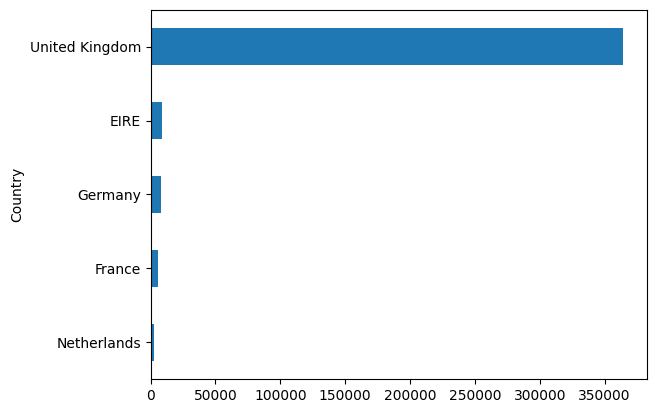

In [26]:
# Top 5 nacionalidades dos clientes
df_cleaned['Country'].value_counts()[:5].sort_values(ascending=True).plot(kind='barh');

### Variáveis Numéricas

In [27]:
df_cleaned.describe(exclude=['object', 'datetime'])

,Quantity,Price
count,400947.00,400947.00
mean,13.77,3.31
std,97.64,35.05
min,1.00,0.00
25%,2.00,1.25
50%,5.00,1.95
75%,12.00,3.75
max,19152.00,10953.50


- Presença de valor 0 na variável `Price`
- Presença de outliers detectada em ambas as variáveis!

In [28]:
df_cleaned[df_cleaned['Price'] == 0].head(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
4674,489825,22076,6 RIBBONS EMPIRE,12,2009-12-02 13:34:00,0.00,16126.00,United Kingdom
6781,489998,48185,DOOR MAT FAIRY CAKE,2,2009-12-03 11:19:00,0.00,15658.00,United Kingdom
16107,490727,M,Manual,1,2009-12-07 16:38:00,0.00,17231.00,United Kingdom
18738,490961,22065,CHRISTMAS PUDDING TRINKET POT,1,2009-12-08 15:25:00,0.00,14108.00,United Kingdom
18739,490961,22142,CHRISTMAS CRAFT WHITE FAIRY,12,2009-12-08 15:25:00,0.00,14108.00,United Kingdom
32916,492079,85042,ANTIQUE LILY FAIRY LIGHTS,8,2009-12-15 13:49:00,0.00,15070.00,United Kingdom
40101,492760,21143,ANTIQUE GLASS HEART DECORATION,12,2009-12-18 14:22:00,0.00,18071.00,United Kingdom
47126,493761,79320,FLAMINGO LIGHTS,24,2010-01-06 14:54:00,0.00,14258.00,United Kingdom
48342,493899,22355,"CHARLOTTE BAG , SUKI DESIGN",10,2010-01-08 10:43:00,0.00,12417.00,Belgium
57619,494607,21533,RETRO SPOT LARGE MILK JUG,12,2010-01-15 12:43:00,0.00,16858.00,United Kingdom


In [29]:
len(df_cleaned[df_cleaned['Price'] == 0])

31

- São 31 transações com preço igual a 0.
- Pode tratar-se de alguma promoção realizada, ou algo semelhante. No entanto, devido à falta de informações e à baixa quantidade, optarei por não considerar essas observações na análise.

In [30]:
df_cleaned = df_cleaned[df_cleaned['Price'] > 0]

## Feature Engineering

### RFM Features

A análise RFM (Recência, Frequência e Valor Monetário) é uma técnica eficaz para segmentar clientes com base em seu comportamento de compra. Aqui está um resumo de como aplicar essa metodologia:

**Recência (R)**: Refere-se ao tempo decorrido desde a data da última compra do cliente. Isso sugere que os clientes que compraram mais recentemente estão usando nossos produtos, nos contataram recentemente e provavelmente escolherão nossa empresa novamente. Portanto, uma Recência menor, ou seja, mais próxima da data da última compra, resultará em pontuações mais altas.

**Frequência (F)**: É a quantidade de compras realizadas pelo cliente, que pode ser simplesmente pensada como a quantidade de faturas. Quanto mais o cliente escolhe a nossa empresa, mais podemos esperar que ele continue com esse comportamento no futuro.

**Monetário (M)**: Refere-se a quanto dinheiro o cliente pagou por suas compras. Semelhante à Frequência, o valor pago tem um efeito positivo em estar nos segmentos superiores do grupo.

A segmentação RFM ajuda a personalizar as estratégias de marketing, permitindo um melhor direcionamento das ações e aumentando a eficácia nas campanhas.

In [31]:
df_cleaned['TotalValue'] = df_cleaned['Quantity'] * df_cleaned['Price']
df_cleaned

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalValue
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.00,United Kingdom,83.40
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom,81.00
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom,81.00
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.00,United Kingdom,100.80
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.00,United Kingdom,30.00
...,...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530.00,United Kingdom,5.90
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530.00,United Kingdom,3.75
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530.00,United Kingdom,3.75
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530.00,United Kingdom,7.50


In [32]:
# Agrupando os cliente por (Valor total gasto, Quantas vezes comprou, Data da última compra)
df_rfm = df_cleaned.groupby(by="Customer ID").agg(Monetary=("TotalValue", "sum"),
                                                  Frequency=("Invoice", "nunique"),
                                                  LastInvoice=("InvoiceDate", "max")).reset_index()

In [33]:
df_rfm

,Customer ID,Monetary,Frequency,LastInvoice
0,12346.00,372.86,11,2010-06-28 13:53:00
1,12347.00,1323.32,2,2010-12-07 14:57:00
2,12348.00,222.16,1,2010-09-27 14:59:00
3,12349.00,2671.14,3,2010-10-28 08:23:00
4,12351.00,300.93,1,2010-11-29 15:23:00
...,...,...,...,...
4307,18283.00,619.37,6,2010-11-22 15:30:00
4308,18284.00,461.68,1,2010-10-04 11:33:00
4309,18285.00,427.00,1,2010-02-17 10:24:00
4310,18286.00,1296.43,2,2010-08-20 11:57:00


In [34]:
df_rfm[df_rfm['Customer ID'] == 12682.00]

,Customer ID,Monetary,Frequency,LastInvoice
210,12682.00,11745.69,23,2010-12-09 14:49:00


In [35]:
max_invoice_date = df_rfm["LastInvoice"].max()
df_rfm["Recency"] = (max_invoice_date - df_rfm["LastInvoice"]).dt.days

In [36]:
max_invoice_date

Timestamp('2010-12-09 20:01:00')

In [37]:
df_rfm

,Customer ID,Monetary,Frequency,LastInvoice,Recency
0,12346.00,372.86,11,2010-06-28 13:53:00,164
1,12347.00,1323.32,2,2010-12-07 14:57:00,2
2,12348.00,222.16,1,2010-09-27 14:59:00,73
3,12349.00,2671.14,3,2010-10-28 08:23:00,42
4,12351.00,300.93,1,2010-11-29 15:23:00,10
...,...,...,...,...,...
4307,18283.00,619.37,6,2010-11-22 15:30:00,17
4308,18284.00,461.68,1,2010-10-04 11:33:00,66
4309,18285.00,427.00,1,2010-02-17 10:24:00,295
4310,18286.00,1296.43,2,2010-08-20 11:57:00,111


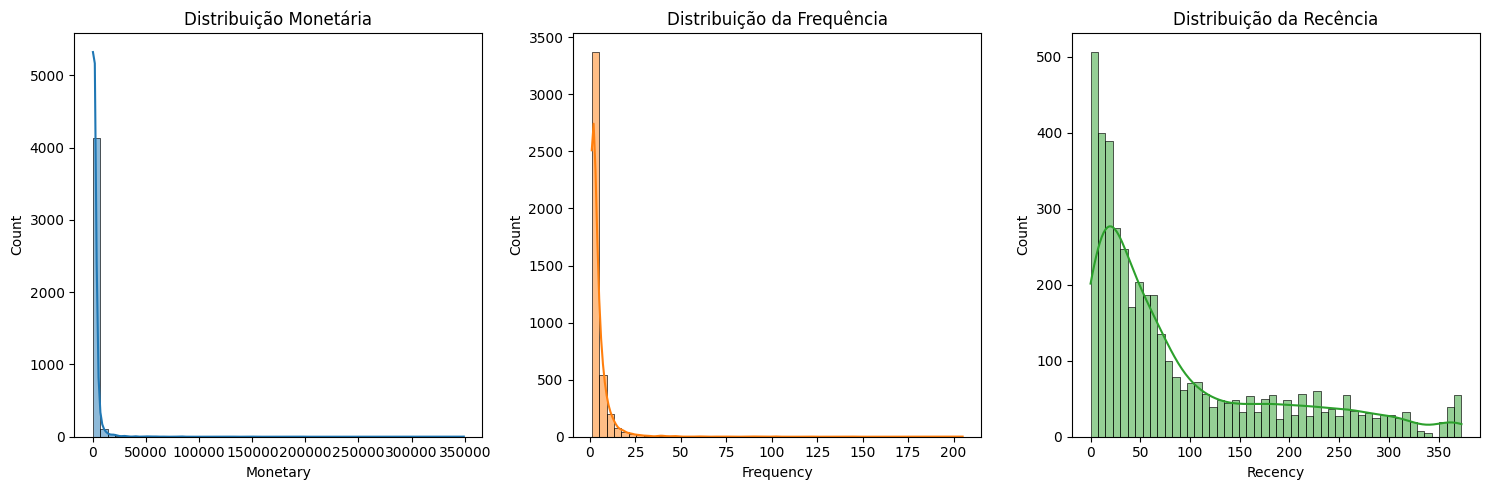

In [38]:
features = ['Monetary', 'Frequency', 'Recency']
titles = ['Distribuição Monetária', 'Distribuição da Frequência', 'Distribuição da Recência']
colors = [BLUE, ORANGE, GREEN]

# Criando os subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Iterando sobre os eixos e variáveis
for ax, feature, title, color in zip(axs, features, titles, colors):
    sns.histplot(df_rfm[feature], kde=True, bins=50, ax=ax, color=color)
    ax.set_title(title)

plt.tight_layout()
plt.show()

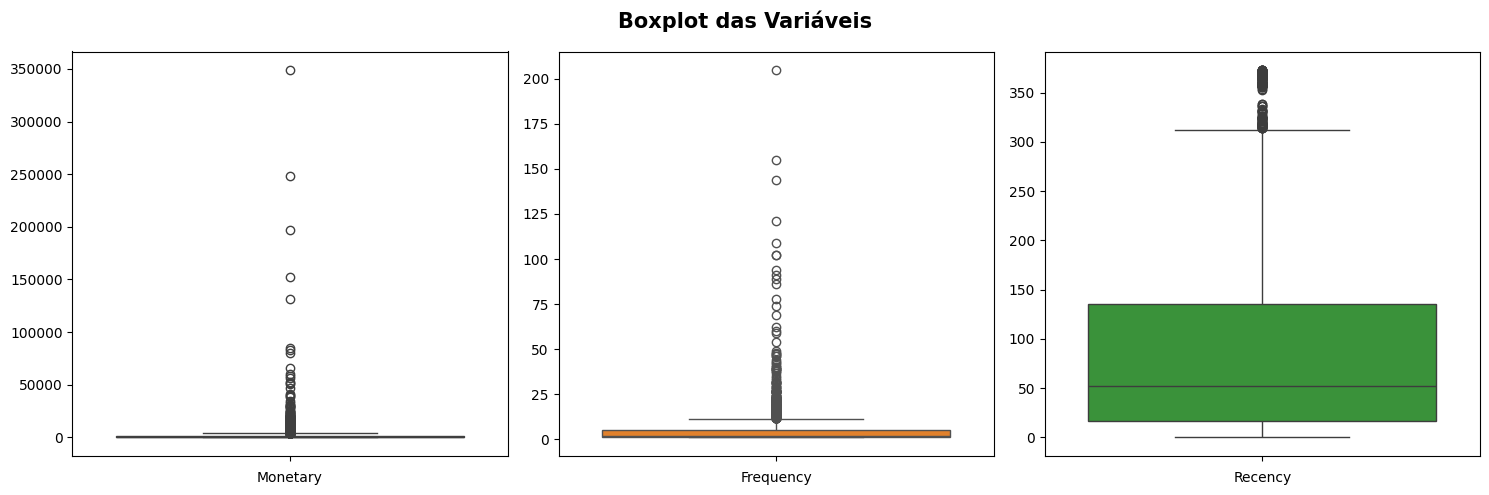

In [39]:
# Criando os subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Iterando sobre os eixos e variáveis
for ax, feature, title, color in zip(axs, features, titles, colors):
    sns.boxplot(df_rfm[feature], ax=ax, color=color)
    ax.set_ylabel('')
    ax.set_xlabel(feature)

plt.suptitle('Boxplot das Variáveis', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

**Observações:**
- Há presença de outliers nas 3 variáveis.
- Clientes com um valor monetário muito acima da média serão analisados separadamente.
- Clientes com uma frequência de compra muita alta também serão analisados separadamente.
- Para seperar os clientes outliers vou utilizar a técnica de IQR (Intervalo Interquartil).

#### Outliers "Valores Monetário"

In [40]:
M_Q1 = df_rfm["Monetary"].quantile(0.25)
M_Q3 = df_rfm["Monetary"].quantile(0.75)
M_IQR = M_Q3 - M_Q1

df_monetary_outliers = df_rfm[(df_rfm["Monetary"] > (M_Q3 + 1.5 * M_IQR)) | (df_rfm["Monetary"] < (M_Q1 - 1.5 * M_IQR))].copy()
df_monetary_outliers

,Customer ID,Monetary,Frequency,LastInvoice,Recency
9,12357.00,12079.99,2,2010-11-16 14:29:00,23
26,12380.00,6951.49,7,2010-08-31 14:54:00,100
44,12409.00,12346.62,4,2010-10-15 10:24:00,55
50,12415.00,19543.84,7,2010-11-29 15:07:00,10
56,12422.00,4428.24,14,2010-11-10 13:19:00,29
...,...,...,...,...,...
4263,18225.00,7539.84,15,2010-12-09 15:46:00,0
4264,18226.00,6650.83,15,2010-11-26 15:51:00,13
4268,18231.00,4782.40,23,2010-10-29 14:17:00,41
4280,18251.00,21964.14,8,2010-09-20 13:26:00,80


In [41]:
df_monetary_outliers.describe()

,Customer ID,Monetary,Frequency,LastInvoice,Recency
count,423.00,423.00,423.00,423,423.00
mean,15053.25,12390.53,17.38,2010-11-09 14:02:30.780141824,29.97
min,12357.00,3851.01,1.00,2010-01-17 11:33:00,0.00
25%,13570.00,4618.52,8.00,2010-11-08 11:33:00,3.00
50%,14918.00,6285.27,12.00,2010-11-26 11:48:00,13.00
75%,16605.00,10451.17,18.50,2010-12-06 09:48:30,31.00
max,18260.00,349164.35,205.00,2010-12-09 19:32:00,326.00
std,1728.48,26182.88,20.59,NaN,49.45


#### Outliers "Frequência"

In [42]:
F_Q1 = df_rfm['Frequency'].quantile(0.25)
F_Q3 = df_rfm['Frequency'].quantile(0.75)
F_IQR = F_Q3 - F_Q1

df_frequency_outliers = df_rfm[(df_rfm['Frequency'] > (F_Q3 + 1.5 * F_IQR)) | (df_rfm['Frequency'] < (F_Q1 - 1.5 * F_IQR))].copy()
df_frequency_outliers

,Customer ID,Monetary,Frequency,LastInvoice,Recency
56,12422.00,4428.24,14,2010-11-10 13:19:00,29
63,12431.00,4370.52,13,2010-12-01 10:03:00,8
67,12437.00,7731.99,21,2010-11-09 14:46:00,30
87,12471.00,20129.54,49,2010-11-30 14:35:00,9
88,12472.00,11308.48,13,2010-12-05 14:19:00,4
...,...,...,...,...,...
4263,18225.00,7539.84,15,2010-12-09 15:46:00,0
4264,18226.00,6650.83,15,2010-11-26 15:51:00,13
4268,18231.00,4782.40,23,2010-10-29 14:17:00,41
4277,18245.00,3757.92,13,2010-11-25 16:52:00,14


In [43]:
df_frequency_outliers.describe()

,Customer ID,Monetary,Frequency,LastInvoice,Recency
count,285.00,285.00,285.00,285,285.00
mean,15307.80,14339.35,23.91,2010-11-23 13:55:24.631578880,15.97
min,12422.00,1091.44,12.00,2010-05-12 16:51:00,0.00
25%,13715.00,4330.46,13.00,2010-11-19 15:51:00,2.00
50%,15311.00,6477.67,17.00,2010-12-02 08:52:00,7.00
75%,16814.00,11535.29,23.00,2010-12-07 10:08:00,20.00
max,18260.00,349164.35,205.00,2010-12-09 19:32:00,211.00
std,1773.26,31520.84,22.83,NaN,25.78


#### Não Outliers

In [44]:
df_no_outliers = df_rfm[(~df_rfm.index.isin(df_monetary_outliers.index)) & (~df_rfm.index.isin(df_frequency_outliers.index))]
df_no_outliers

,Customer ID,Monetary,Frequency,LastInvoice,Recency
0,12346.00,372.86,11,2010-06-28 13:53:00,164
1,12347.00,1323.32,2,2010-12-07 14:57:00,2
2,12348.00,222.16,1,2010-09-27 14:59:00,73
3,12349.00,2671.14,3,2010-10-28 08:23:00,42
4,12351.00,300.93,1,2010-11-29 15:23:00,10
...,...,...,...,...,...
4307,18283.00,619.37,6,2010-11-22 15:30:00,17
4308,18284.00,461.68,1,2010-10-04 11:33:00,66
4309,18285.00,427.00,1,2010-02-17 10:24:00,295
4310,18286.00,1296.43,2,2010-08-20 11:57:00,111


In [45]:
df_no_outliers.describe()

,Customer ID,Monetary,Frequency,LastInvoice,Recency
count,3832.00,3832.00,3832.00,3832,3832.00
mean,15372.73,887.65,2.87,2010-09-02 17:14:08.502087424,97.83
min,12346.00,2.95,1.00,2009-12-01 09:55:00,0.00
25%,13910.50,278.24,1.00,2010-07-07 12:16:15,22.00
50%,15380.50,583.98,2.00,2010-10-12 12:59:30,58.00
75%,16846.25,1269.06,4.00,2010-11-17 13:11:15,155.00
max,18287.00,3824.79,11.00,2010-12-09 20:01:00,373.00
std,1693.48,826.48,2.25,NaN,98.72


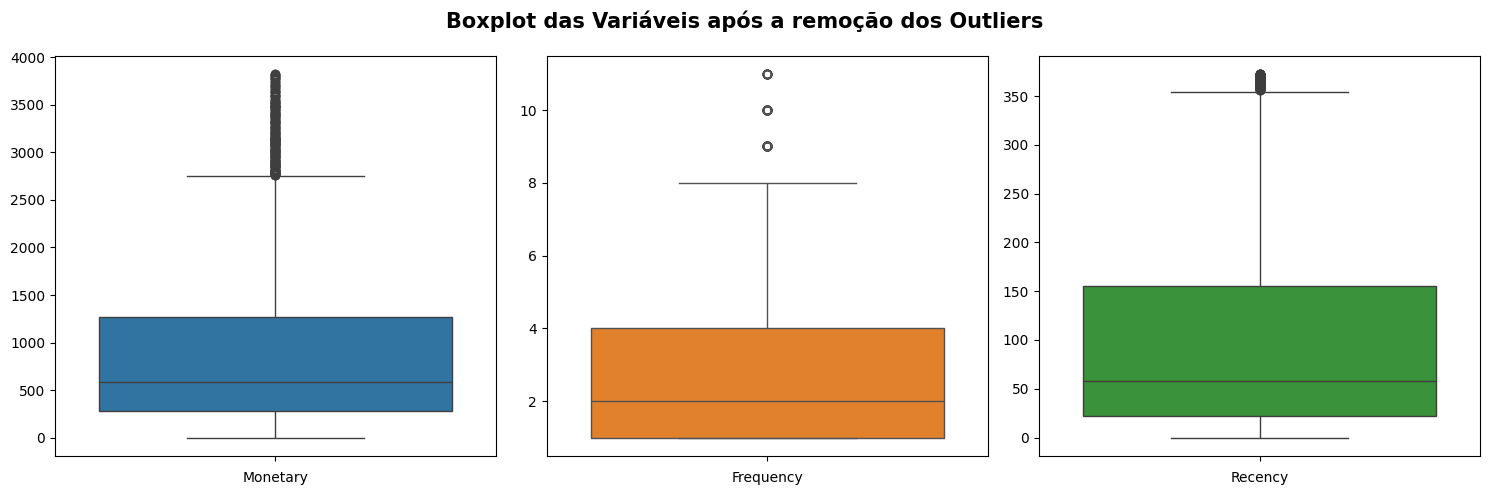

In [46]:
# Criando os subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Iterando sobre os eixos e variáveis
for ax, feature, title, color in zip(axs, features, titles, colors):
    sns.boxplot(df_no_outliers[feature], ax=ax, color=color)
    ax.set_ylabel('')
    ax.set_xlabel(feature)

plt.suptitle('Boxplot das Variáveis após a remoção dos Outliers', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

#### Comparação das Estatísticas Descritivas

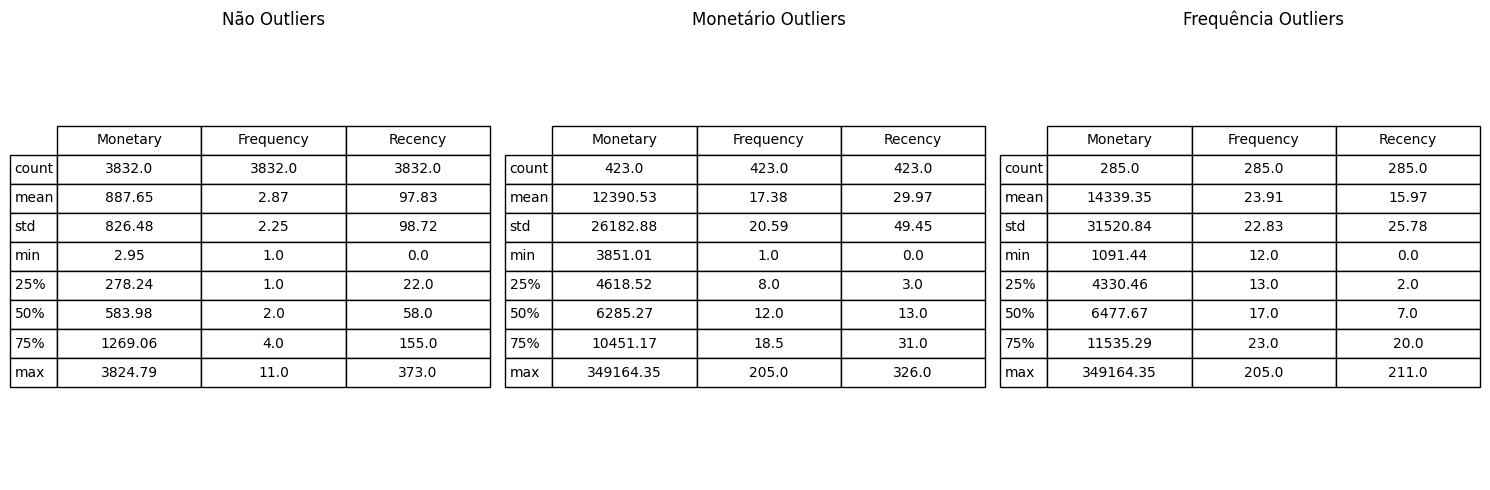

In [47]:
# Criando a figura e os subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Dados para exibição
dfs = [df_no_outliers, df_monetary_outliers, df_frequency_outliers]
titles = ['Não Outliers', 'Monetário Outliers', 'Frequência Outliers']

# Iterando sobre os subplots para adicionar tabelas
for ax, df, title in zip(axs, dfs, titles):
    ax.set_title(title)
    ax.axis('off')  # Esconde os eixos para melhor visualização da tabela
    table = ax.table(cellText=df[['Monetary', 'Frequency', 'Recency']].describe().round(2).values, 
                      colLabels=df[['Monetary', 'Frequency', 'Recency']].columns,
                      rowLabels=df[['Monetary', 'Frequency', 'Recency']].describe().index,
                      cellLoc='center', loc='center')
    table.scale(1, 1.5)  # Ajusta o tamanho da tabela

plt.tight_layout()
plt.show()

## Pré-Processamento - Standard Scale

In [48]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_no_outliers[["Monetary", "Frequency", "Recency"]])
df_scaled = pd.DataFrame(scaled_data, index=df_no_outliers.index, columns=("Monetary", "Frequency", "Recency"))

In [49]:
df_scaled

,Monetary,Frequency,Recency
0,-0.62,3.62,0.67
1,0.53,-0.39,-0.97
2,-0.81,-0.83,-0.25
3,2.16,0.06,-0.57
4,-0.71,-0.83,-0.89
...,...,...,...
4307,-0.32,1.39,-0.82
4308,-0.52,-0.83,-0.32
4309,-0.56,-0.83,2.00
4310,0.49,-0.39,0.13


## Modelagem - KMeans Clustering

O **K-means** é um algoritmo de aprendizado não supervisionado amplamente utilizada para agrupamento (clustering) de dados, visando dividir o conjunto de dados em K grupos (clusters), onde cada ponto de dado pertence ao grupo cujo centroide (o ponto médio do cluster) é mais próximo.

A **inércia** (inertia) é uma métrica utilizada no algoritmo K-means para avaliar a qualidade dos clusters formados. Ela mede a soma das distâncias quadráticas entre cada ponto de dado e o centroide do cluster ao qual pertence. Utiliza-se o método do cotovelo (Elbow Method) para avaliar a inércia. Uma inércia menor indica que os pontos de dados estão mais próximos de seus respectivos centroides, sugerindo que o agrupamento é mais compacto e, portanto, de melhor qualidade.

O **Silhouette Score** é uma métrica utilizada para avaliar a qualidade de um agrupamento (clustering). Ele mede o quão bem cada ponto de dado se encaixa em seu próprio cluster em comparação com outros clusters. Essa métrica varia de -1 a +1, onde:

- +1: O ponto está bem agrupado com outros pontos do mesmo cluster e longe de outros clusters.
- 0: O ponto está perto da borda entre dois clusters, o que indica que pode estar mal classificado.
- -1: O ponto pode estar mal alocado, pois está mais próximo de um cluster diferente.

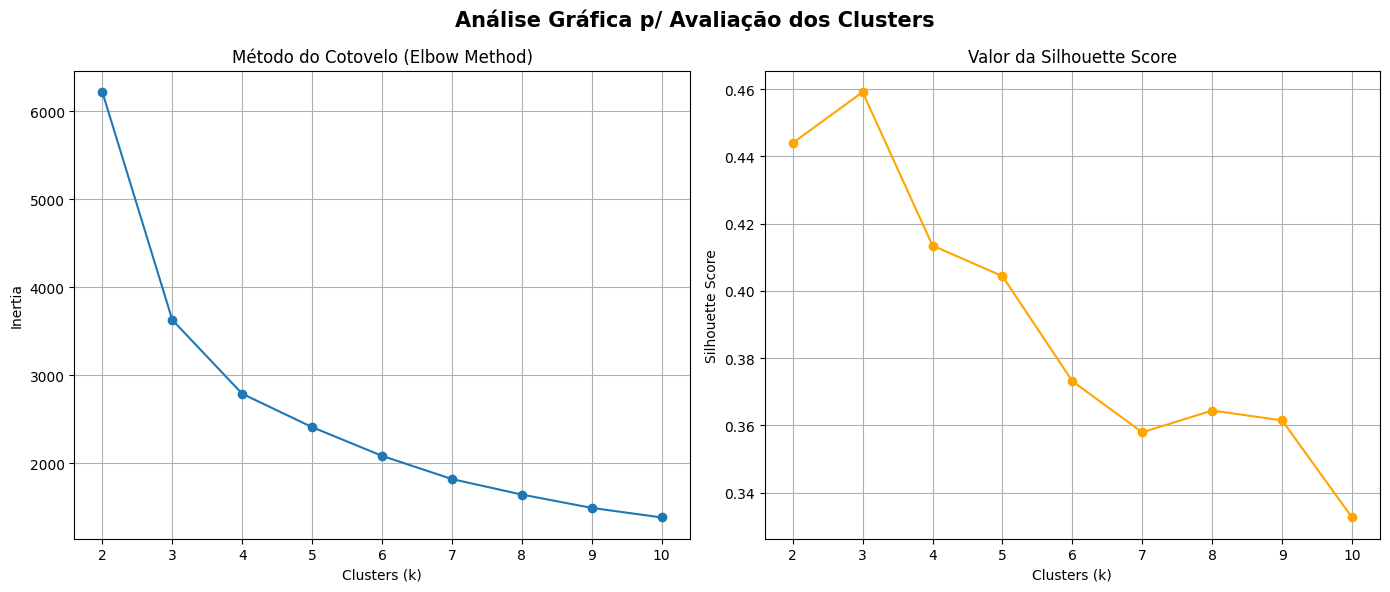

In [50]:
np.random.seed(0)
max_k = 10

inertia = []
silhoutte_scores = []
k_values = range(2, max_k + 1)

for k in k_values:

    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=1000, n_init=10, random_state=43)
    kmeans.fit(df_scaled)
    labels = kmeans.labels_
    sil_score = silhouette_score(df_scaled, labels)
    silhoutte_scores.append(sil_score)
    inertia.append(kmeans.inertia_)

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(k_values, inertia, marker='o')
plt.title('Método do Cotovelo (Elbow Method)')
plt.xlabel('Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(k_values, silhoutte_scores, marker='o', color='orange')
plt.title('Valor da Silhouette Score')
plt.xlabel('Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_values)
plt.grid(True)

plt.suptitle('Análise Gráfica p/ Avaliação dos Clusters', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

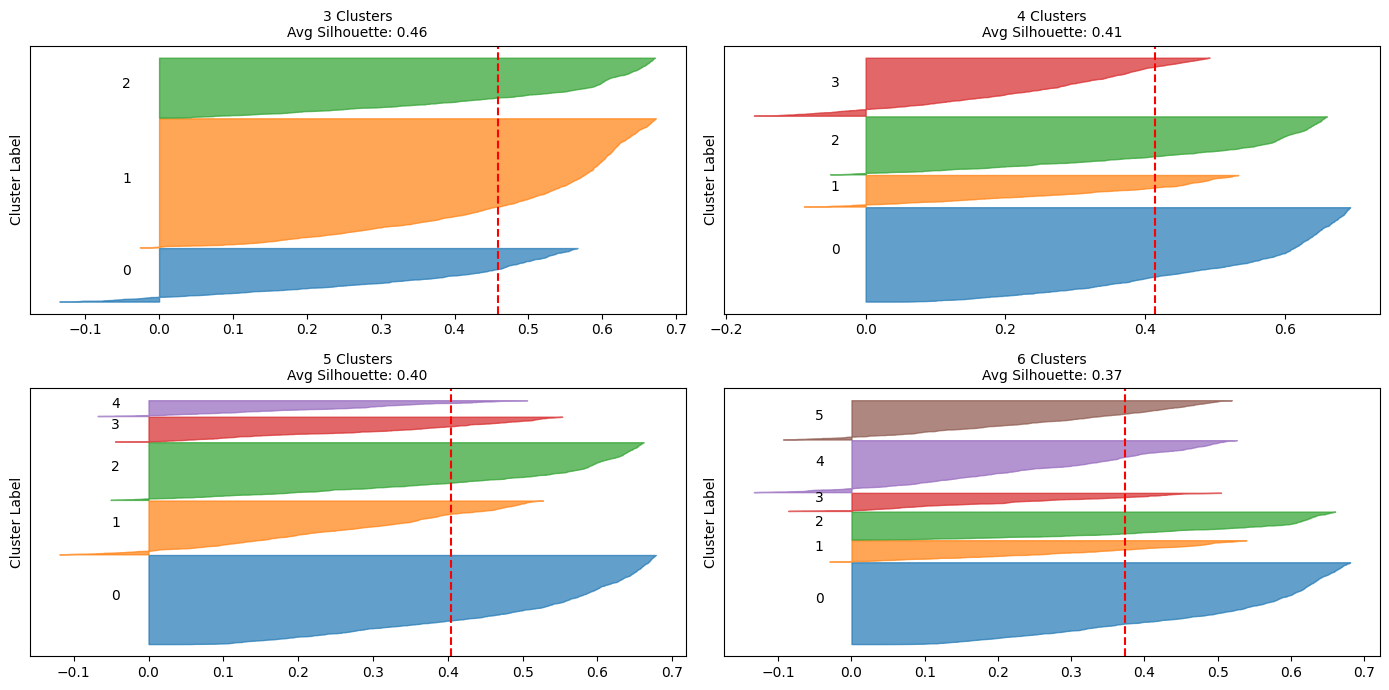

In [51]:
# Analisando os diagramas de Silhouette para diversos valores de clusters.
cluster_list = [3, 4, 5, 6]
plot_silhouette_analysis(df_scaled, n_clusters=cluster_list, n_cols=2)

In [52]:
np.random.seed(0)
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=1000, n_init=10, random_state=43)
cluster_labels = kmeans.fit_predict(df_scaled)
cluster_labels

array([1, 3, 0, ..., 2, 3, 3])

In [53]:
df_no_outliers["Cluster"] = cluster_labels
df_no_outliers

,Customer ID,Monetary,Frequency,LastInvoice,Recency,Cluster
0,12346.00,372.86,11,2010-06-28 13:53:00,164,1
1,12347.00,1323.32,2,2010-12-07 14:57:00,2,3
2,12348.00,222.16,1,2010-09-27 14:59:00,73,0
3,12349.00,2671.14,3,2010-10-28 08:23:00,42,3
4,12351.00,300.93,1,2010-11-29 15:23:00,10,0
...,...,...,...,...,...,...
4307,18283.00,619.37,6,2010-11-22 15:30:00,17,3
4308,18284.00,461.68,1,2010-10-04 11:33:00,66,0
4309,18285.00,427.00,1,2010-02-17 10:24:00,295,2
4310,18286.00,1296.43,2,2010-08-20 11:57:00,111,3


#### Análise com Gráfico 3D

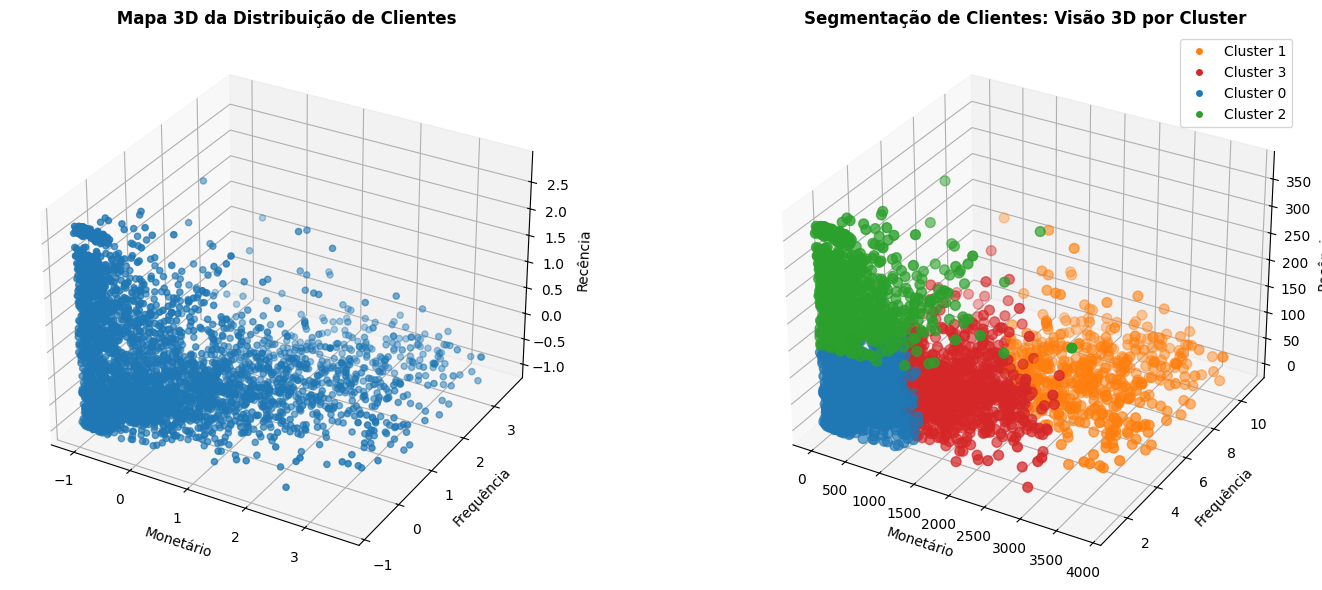

In [54]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6), subplot_kw={'projection': '3d'})

# Gráfico 1: Distribuição dos Clientes 
scatter1 = axs[0].scatter(df_scaled["Monetary"], df_scaled["Frequency"], df_scaled["Recency"])

axs[0].set_xlabel('Monetário')
axs[0].set_ylabel('Frequência')
axs[0].set_zlabel('Recência')
axs[0].set_title(' Mapa 3D da Distribuição de Clientes', fontweight='bold')

# Gráfico 2: Clientes por Cluster 
cluster_colors = {0: PALETA[0], 1: PALETA[1], 2: PALETA[2], 3: PALETA[3]}
colors = df_no_outliers['Cluster'].map(cluster_colors)

scatter2 = axs[1].scatter(df_no_outliers['Monetary'], 
                          df_no_outliers['Frequency'], 
                          df_no_outliers['Recency'], 
                          c=colors, marker='o', s=50)

axs[1].set_xlabel('Monetário')
axs[1].set_ylabel('Frequência')
axs[1].set_zlabel('Recência')
axs[1].set_title('Segmentação de Clientes: Visão 3D por Cluster', fontweight='bold')

# Adicionando uma legenda ao segundo gráfico
unique_clusters = df_no_outliers['Cluster'].unique()
handles = [plt.Line2D([0], [0], marker='o', color='w', label=f'Cluster {i}', 
                       markerfacecolor=cluster_colors[i]) for i in unique_clusters]
axs[1].legend(handles=handles, loc='upper right')

plt.tight_layout()
plt.show()

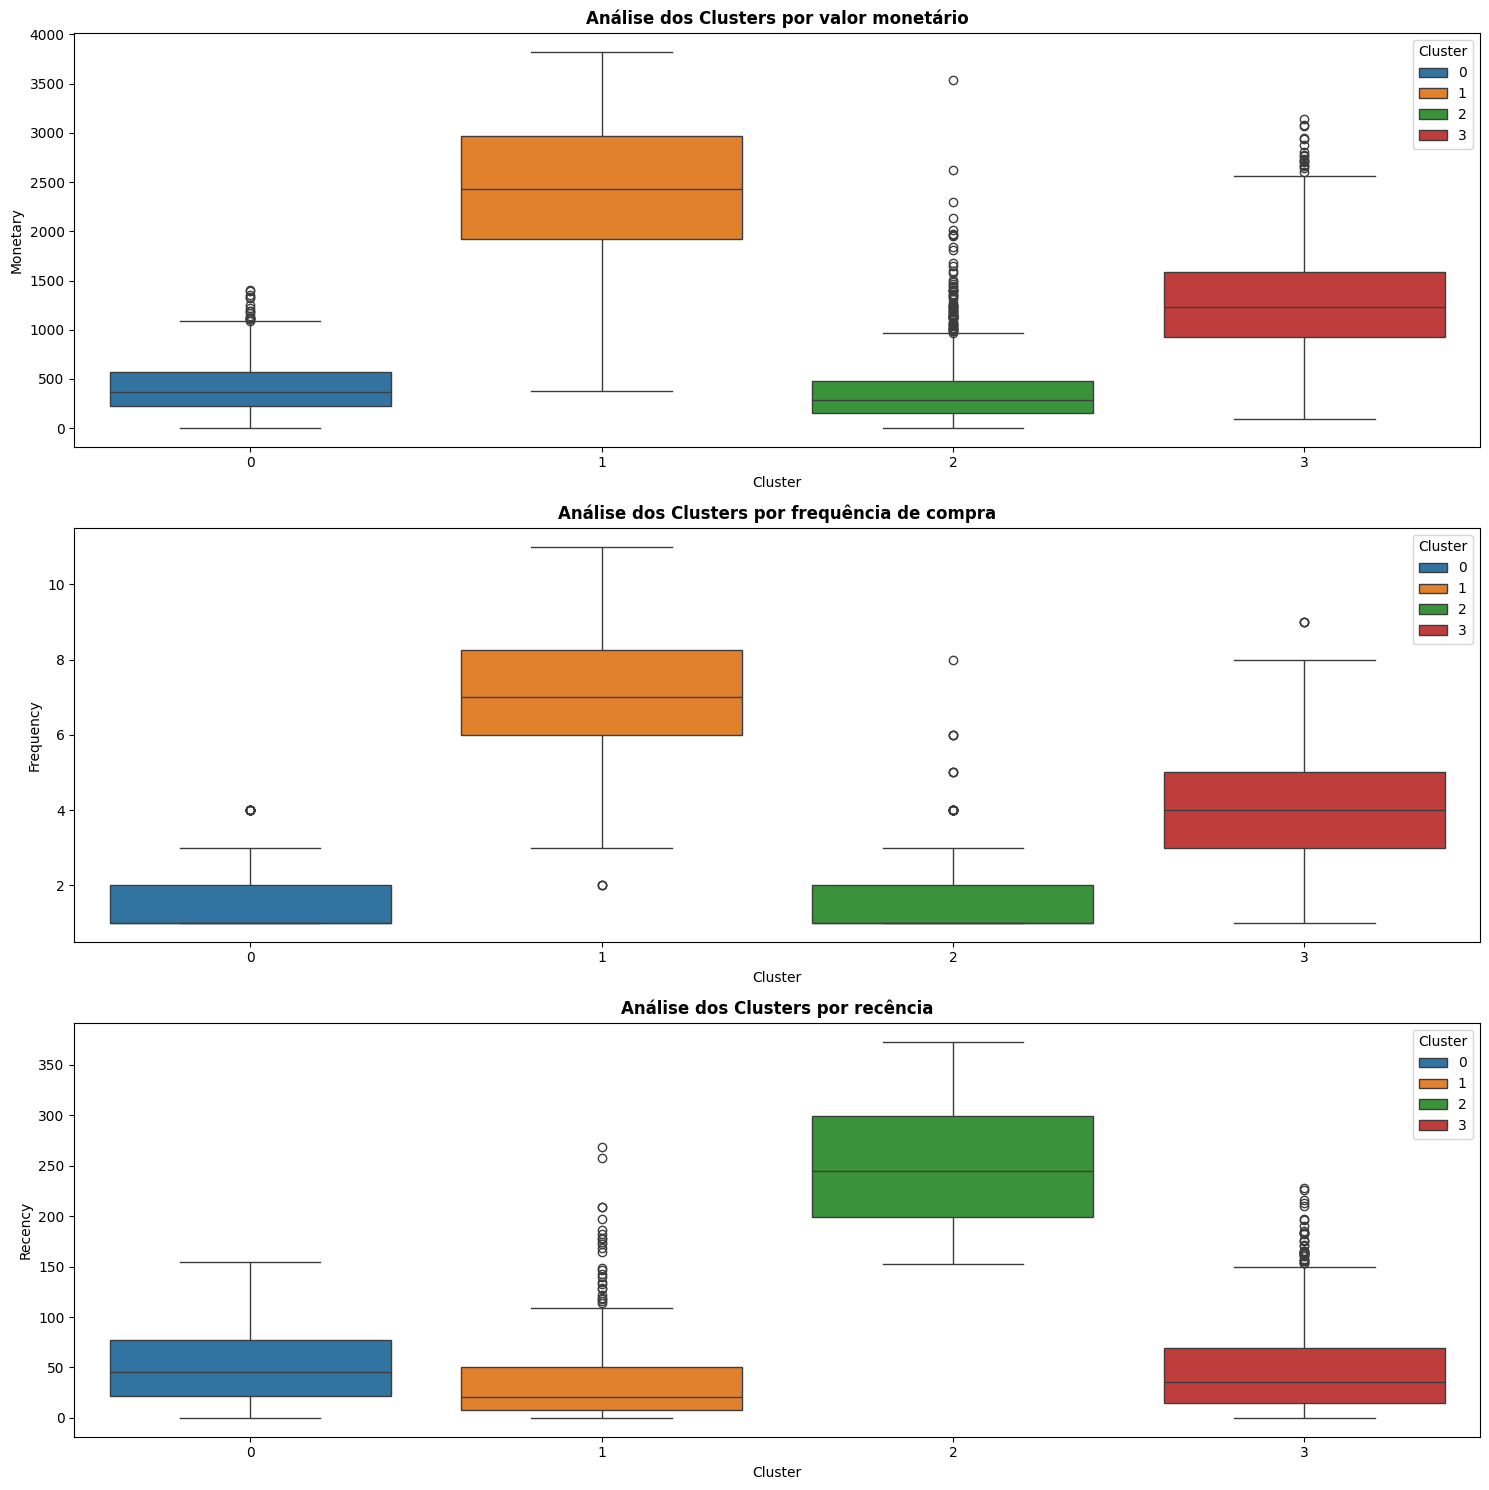

In [55]:
# Criando subplots
fig, axs = plt.subplots(3, 1, figsize=(15, 15))

# Definição das variáveis
features = ['Monetary', 'Frequency', 'Recency']
titles = ['Análise dos Clusters por valor monetário', 
          'Análise dos Clusters por frequência de compra', 
          'Análise dos Clusters por recência']

# Gerando os boxplots de forma dinâmica
for ax, feature, title in zip(axs, features, titles):
    sns.boxplot(data=df_no_outliers, x='Cluster', y=feature, palette=cluster_colors, hue='Cluster', ax=ax)
    ax.set_title(title, fontweight='bold')

plt.tight_layout()
plt.show()

In [56]:
df_no_outliers.groupby('Cluster').agg(Monetary=('Monetary', 'mean'),
                                     Frequency=('Frequency', 'mean'), 
                                     Recency=('Recency', 'mean')).round(2).reset_index()

,Cluster,Monetary,Frequency,Recency
0,0,414.92,1.65,54.07
1,1,2453.05,7.22,34.66
2,2,389.69,1.43,252.12
3,3,1302.40,3.93,49.29


#### Análise de Clientes Outliers

- Clientes com um valor monetário muito acima da média.
- Clientes com uma frequência de compra muito acima da média.

In [57]:
# Clientes que estão nos outliers de valor monetário e frequência
overlap_indices = df_monetary_outliers.index.intersection(df_frequency_outliers.index)

# Clientes com alto valor monetário 
monetary_only_outliers = df_monetary_outliers.drop(overlap_indices)

# Clientes com alta frequência nas compras
frequency_only_outliers = df_frequency_outliers.drop(overlap_indices)

# Clientes que estão nos outliers de valor monetário e frequência
monetary_and_frequency_outliers = df_monetary_outliers.loc[overlap_indices]

# Atribuindo um clusters a esses clientes manualmente
monetary_only_outliers["Cluster"] = -1
frequency_only_outliers["Cluster"] = -2
monetary_and_frequency_outliers["Cluster"] = -3

outlier_clusters_df = pd.concat([monetary_only_outliers, frequency_only_outliers, monetary_and_frequency_outliers])
outlier_clusters_df

,Customer ID,Monetary,Frequency,LastInvoice,Recency,Cluster
9,12357.00,12079.99,2,2010-11-16 14:29:00,23,-1
26,12380.00,6951.49,7,2010-08-31 14:54:00,100,-1
44,12409.00,12346.62,4,2010-10-15 10:24:00,55,-1
50,12415.00,19543.84,7,2010-11-29 15:07:00,10,-1
64,12433.00,7205.39,5,2010-12-08 16:49:00,1,-1
...,...,...,...,...,...,...
4262,18223.00,7516.31,12,2010-11-17 12:20:00,22,-3
4263,18225.00,7539.84,15,2010-12-09 15:46:00,0,-3
4264,18226.00,6650.83,15,2010-11-26 15:51:00,13,-3
4268,18231.00,4782.40,23,2010-10-29 14:17:00,41,-3


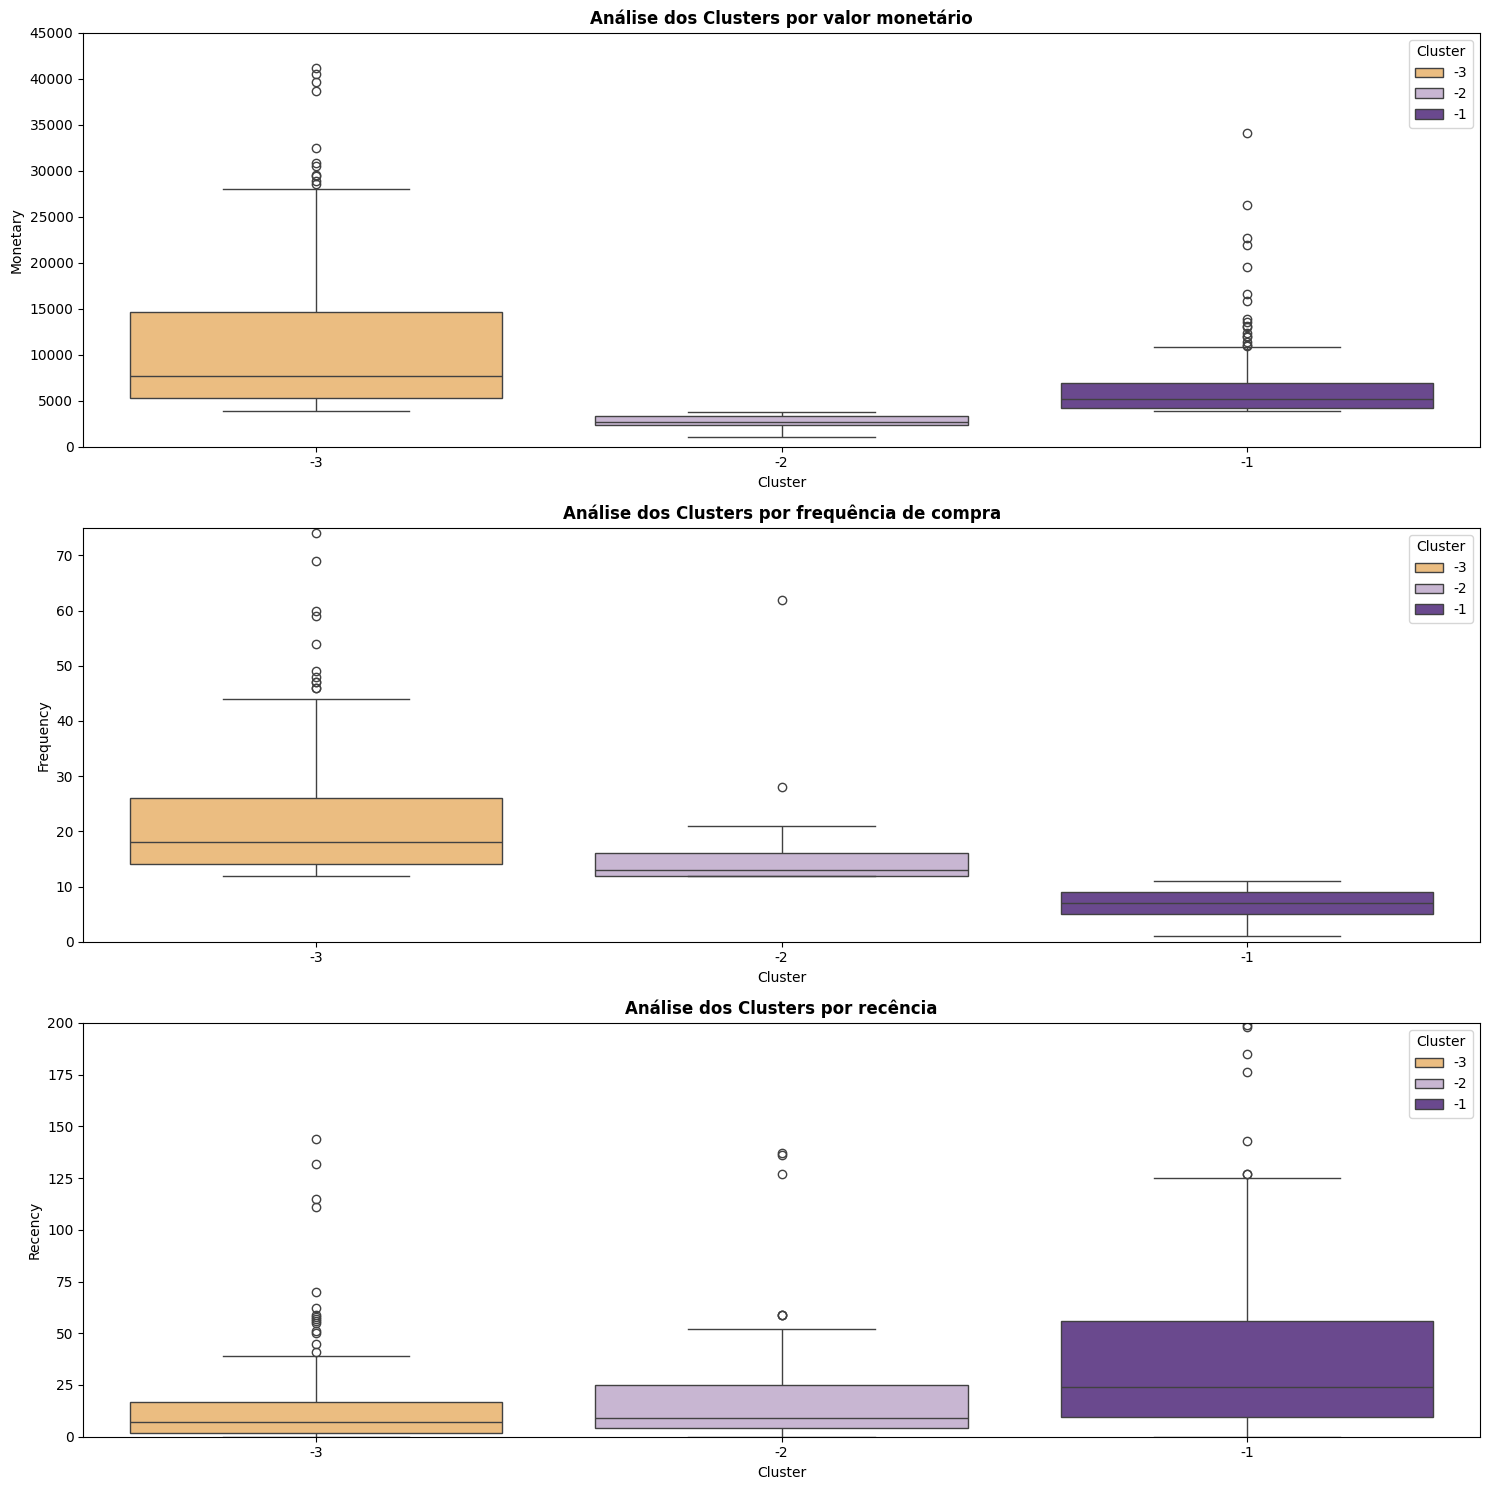

In [58]:
# Criando subplots
fig, axs = plt.subplots(3, 1, figsize=(15, 15))

# Cores
cluster_colors = {-1: PURPLE,
                  -2: LIGHT_PURPLE,
                  -3: YELLOW}

# Definição das variáveis
features = ['Monetary', 'Frequency', 'Recency']
titles = ['Análise dos Clusters por valor monetário', 
          'Análise dos Clusters por frequência de compra', 
          'Análise dos Clusters por recência']
ylim_ranges = [(0, 45000), (0, 75), (0, 200)]  # Intervalos para Y (mínimo, máximo)

# Loop para criar os gráficos com limites ajustados
for ax, feature, title, ylim in zip(axs, features, titles, ylim_ranges):
    sns.boxplot(data=outlier_clusters_df, x='Cluster', y=feature, palette=cluster_colors, hue='Cluster', ax=ax)
    ax.set_title(title, fontweight='bold')
    ax.set_ylim(ylim)  # Define o intervalo do eixo Y

plt.tight_layout()
plt.show()

In [59]:
outlier_clusters_df.groupby('Cluster').agg(Monetary=('Monetary', 'mean'),
                                            Frequency=('Frequency', 'mean'), 
                                            Recency=('Recency', 'mean')).round(2).reset_index()

,Cluster,Monetary,Frequency,Recency
0,-3,17241.87,26.09,14.51
1,-2,2729.25,15.18,21.81
2,-1,6718.20,7.19,48.04


## Segmentação e Estratégia de Engajamento

In [60]:
df_full_clustering = pd.concat([df_no_outliers, outlier_clusters_df])
df_full_clustering = df_full_clustering[['Customer ID', 'Cluster', 'Monetary', 'Frequency', 'Recency']]

In [61]:
df_full_clustering

,Customer ID,Cluster,Monetary,Frequency,Recency
0,12346.00,1,372.86,11,164
1,12347.00,3,1323.32,2,2
2,12348.00,0,222.16,1,73
3,12349.00,3,2671.14,3,42
4,12351.00,0,300.93,1,10
...,...,...,...,...,...
4262,18223.00,-3,7516.31,12,22
4263,18225.00,-3,7539.84,15,0
4264,18226.00,-3,6650.83,15,13
4268,18231.00,-3,4782.40,23,41


In [62]:
df_full_clustering_agrupado = df_full_clustering.groupby('Cluster').agg(Monetary=('Monetary', 'mean'),
                                            Frequency=('Frequency', 'mean'), 
                                            Recency=('Recency', 'mean')).round(2).reset_index()

In [63]:
df_full_clustering_agrupado

,Cluster,Monetary,Frequency,Recency
0,-3,17241.87,26.09,14.51
1,-2,2729.25,15.18,21.81
2,-1,6718.20,7.19,48.04
3,0,414.92,1.65,54.07
4,1,2453.05,7.22,34.66
5,2,389.69,1.43,252.12
6,3,1302.40,3.93,49.29


In [64]:
df_full_clustering_agrupado['Frequency'] = round(df_full_clustering_agrupado['Frequency']).astype('int')
df_full_clustering_agrupado['Recency'] = round(df_full_clustering_agrupado['Recency']).astype('int')

In [65]:
df_full_clustering_agrupado

,Cluster,Monetary,Frequency,Recency
0,-3,17241.87,26,15
1,-2,2729.25,15,22
2,-1,6718.20,7,48
3,0,414.92,2,54
4,1,2453.05,7,35
5,2,389.69,1,252
6,3,1302.40,4,49


| Cluster | Tipo de Cliente      | Características principais                                             | Estratégia de Engajamento                         |
|---------|---------------------|------------------------------------------------------------------------|--------------------------------------------------|
| **-3**  | Cliente VIP         | Alto gasto (R$17.241,87), alta frequência (26 compras), recência curta (15 dias) | Benefícios exclusivos, atendimento premium      |
| **-2**  | Cliente Fiel        | Bom gasto (R$2.729,25), compras frequentes (15 compras), ativo (22 dias) | Programas de fidelidade, descontos personalizados |
| **-1**  | Cliente Regular     | Gasto médio (R$6.718,20), menor frequência (7 compras), recência moderada (48 dias) | Campanhas de remarketing, recomendações personalizadas |
| **0**   | Cliente Ocasional   | Valor médio (R$414,92), baixa frequência (2 compras), recência um pouco alta (54 dias) | Promoções para aumentar a recorrência de compras |
| **1**   | Cliente em Risco    | Gasto razoável (R$2.453,05), frequência baixa (7 compras), recência maior (35 dias) | Cupons de incentivo, campanhas para retenção |
| **2**   | Cliente Perdido     | Baixo gasto (R$389,69), raras compras (1 vez), muito tempo sem comprar (252 dias) | E-mails de reconquista, ofertas agressivas |
| **3**   | Cliente Inativo     | Baixo gasto (R$1.302,40), frequência mínima (4 compras), recência alta (49 dias) | Estratégia de reativação, descontos personalizados |

In [66]:
cluster_labels = {
    -3: "VIP",
    -2: "Fiel",
    -1: "Regular",
    0: "Ocasional",
    1: "Risco",
    2: "Perdido",
    3: "Inativo"
}

cluster_strategy = {
    -3: "Benefícios exclusivos, atendimento premium",
    -2: "Programas de fidelidade, descontos personalizados",
    -1: "Campanhas de remarketing, recomendações personalizadas",
    0: "Promoções para aumentar a recorrência de compras",
    1: "Cupons de incentivo, campanhas para retenção",
    2: "E-mails de reconquista, ofertas agressivas",
    3: "Estratégia de reativação, descontos personalizados",
}

In [67]:
df_full_clustering["ClusterLabel"] = df_full_clustering["Cluster"].map(cluster_labels)
df_full_clustering["ClusterStrategy"] = df_full_clustering["Cluster"].map(cluster_strategy)

In [68]:
df_full_clustering

,Customer ID,Cluster,Monetary,Frequency,Recency,ClusterLabel,ClusterStrategy
0,12346.00,1,372.86,11,164,Risco,"Cupons de incentivo, campanhas para retenção"
1,12347.00,3,1323.32,2,2,Inativo,"Estratégia de reativação, descontos personaliz..."
2,12348.00,0,222.16,1,73,Ocasional,Promoções para aumentar a recorrência de compras
3,12349.00,3,2671.14,3,42,Inativo,"Estratégia de reativação, descontos personaliz..."
4,12351.00,0,300.93,1,10,Ocasional,Promoções para aumentar a recorrência de compras
...,...,...,...,...,...,...,...
4262,18223.00,-3,7516.31,12,22,VIP,"Benefícios exclusivos, atendimento premium"
4263,18225.00,-3,7539.84,15,0,VIP,"Benefícios exclusivos, atendimento premium"
4264,18226.00,-3,6650.83,15,13,VIP,"Benefícios exclusivos, atendimento premium"
4268,18231.00,-3,4782.40,23,41,VIP,"Benefícios exclusivos, atendimento premium"


In [69]:
qtd_clientes_clusters = df_full_clustering['ClusterLabel'].value_counts()
pct_qtd_clientes_clusters = round(df_full_clustering['ClusterLabel'].value_counts(normalize=True) * 100).astype('int')

In [70]:
df_clusters = pd.DataFrame({
    'Quantidade de Clientes': qtd_clientes_clusters,
    'Porcentagem': pct_qtd_clientes_clusters
}).reset_index().rename(columns={'index': 'ClusterLabel'})

In [71]:
ordem_clusters = ["VIP", "Fiel", "Regular", "Ocasional", "Risco", "Inativo", "Perdido"]  # Ordem desejada
df_clusters['ClusterLabel'] = pd.Categorical(df_clusters['ClusterLabel'], categories=ordem_clusters, ordered=True)
df_clusters = df_clusters.sort_values('ClusterLabel')

In [73]:
df_clusters['Porcentagem'] = df_clusters['Porcentagem'].astype(str) + "%"

In [74]:
df_clusters

,ClusterLabel,Quantidade de Clientes,Porcentagem
4,VIP,228,5%
6,Fiel,57,1%
5,Regular,195,5%
0,Ocasional,1495,35%
3,Risco,500,12%
1,Inativo,919,21%
2,Perdido,918,21%


In [75]:
# Salvando em um arquivo xlsx (excel)
df_full_clustering.to_excel('../reports/clientes_clustering.xlsx', index=False)
df_clusters.to_excel('../reports/qtd_clientes_clustering.xlsx', index=False)

### Visualização dos Clusters p/ RFM

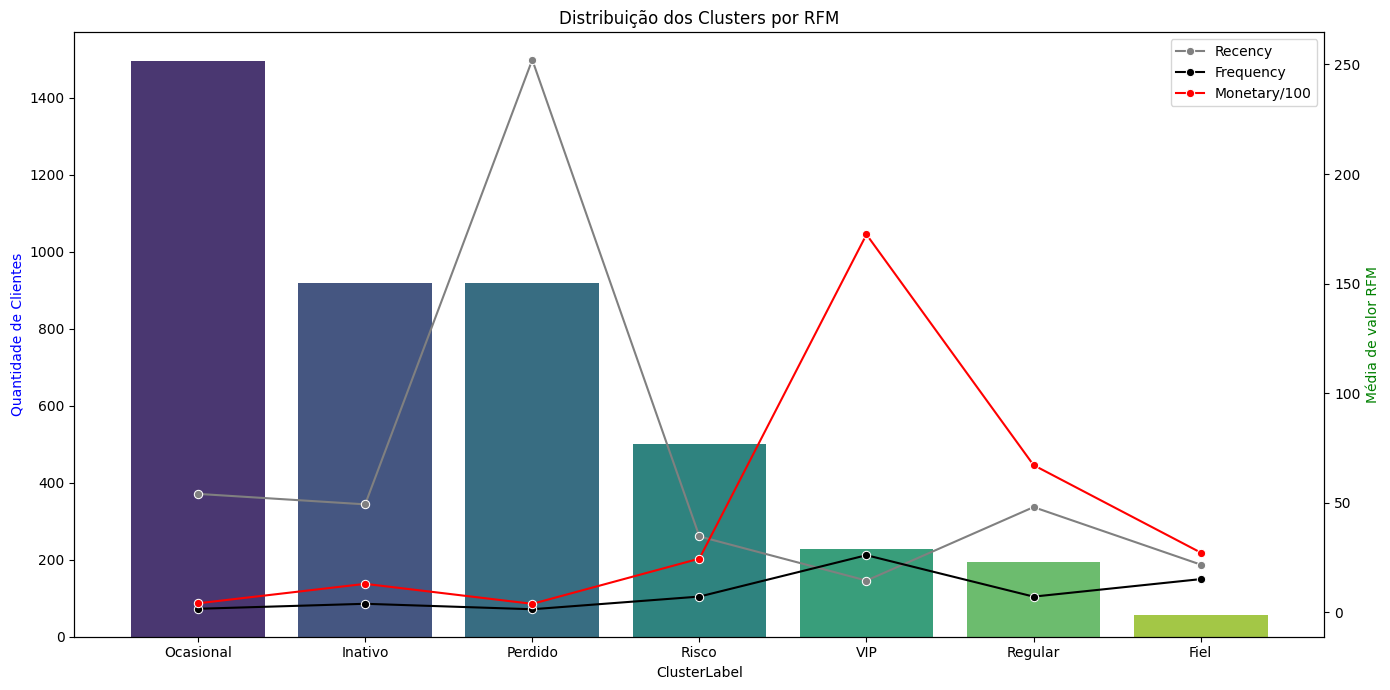

In [76]:
# Visualização Gráfica do projeto final
cluster_counts = df_full_clustering['ClusterLabel'].value_counts()
df_full_clustering["Monetary/100"] = df_full_clustering["Monetary"] / 100.00
feature_means = df_full_clustering.groupby('ClusterLabel')[['Recency', 'Frequency', 'Monetary/100']].mean()

fig, ax1 = plt.subplots(figsize=(14, 7))

sns.barplot(x=cluster_counts.index, y=cluster_counts.values, ax=ax1, palette='viridis', hue=cluster_counts.index)
ax1.set_ylabel('Quantidade de Clientes', color='b')
ax1.set_title('Distribuição dos Clusters por RFM')

ax2 = ax1.twinx()

sns.lineplot(data=feature_means, x='ClusterLabel', y='Recency', ax=ax2, label='Recency', color='gray', marker='o')
sns.lineplot(data=feature_means, x='ClusterLabel', y='Frequency', ax=ax2, label='Frequency', color='black', marker='o')
sns.lineplot(data=feature_means, x='ClusterLabel', y='Monetary/100', ax=ax2, label='Monetary/100', color='red', marker='o')
ax2.set_ylabel('Média de valor RFM', color='g')

plt.tight_layout()
plt.show()

## Análise de Churn

In [77]:
df_full_clustering

,Customer ID,Cluster,Monetary,Frequency,Recency,ClusterLabel,ClusterStrategy,Monetary/100
0,12346.00,1,372.86,11,164,Risco,"Cupons de incentivo, campanhas para retenção",3.73
1,12347.00,3,1323.32,2,2,Inativo,"Estratégia de reativação, descontos personaliz...",13.23
2,12348.00,0,222.16,1,73,Ocasional,Promoções para aumentar a recorrência de compras,2.22
3,12349.00,3,2671.14,3,42,Inativo,"Estratégia de reativação, descontos personaliz...",26.71
4,12351.00,0,300.93,1,10,Ocasional,Promoções para aumentar a recorrência de compras,3.01
...,...,...,...,...,...,...,...,...
4262,18223.00,-3,7516.31,12,22,VIP,"Benefícios exclusivos, atendimento premium",75.16
4263,18225.00,-3,7539.84,15,0,VIP,"Benefícios exclusivos, atendimento premium",75.40
4264,18226.00,-3,6650.83,15,13,VIP,"Benefícios exclusivos, atendimento premium",66.51
4268,18231.00,-3,4782.40,23,41,VIP,"Benefícios exclusivos, atendimento premium",47.82


In [78]:
# Define churn threshold (e.g., 180 dias desde a última compra)
churn_threshold = 180
churned_customers = df_full_clustering[df_full_clustering['Recency'] > churn_threshold]
churned_customers

,Customer ID,Cluster,Monetary,Frequency,Recency,ClusterLabel,ClusterStrategy,Monetary/100
7,12355.00,2,488.21,1,202,Perdido,"E-mails de reconquista, ofertas agressivas",4.88
14,12362.00,2,130.00,1,373,Perdido,"E-mails de reconquista, ofertas agressivas",1.30
15,12366.00,2,500.24,1,268,Perdido,"E-mails de reconquista, ofertas agressivas",5.00
16,12368.00,2,917.70,1,263,Perdido,"E-mails de reconquista, ofertas agressivas",9.18
18,12370.00,2,774.62,3,259,Perdido,"E-mails de reconquista, ofertas agressivas",7.75
...,...,...,...,...,...,...,...,...
2712,16118.00,-1,4376.25,1,287,Regular,"Campanhas de remarketing, recomendações person...",43.76
3175,16749.00,-1,4157.88,2,226,Regular,"Campanhas de remarketing, recomendações person...",41.58
3531,17230.00,-1,5750.08,10,198,Regular,"Campanhas de remarketing, recomendações person...",57.50
4144,18052.00,-1,10877.18,1,199,Regular,"Campanhas de remarketing, recomendações person...",108.77


In [79]:
churned_customers['ClusterLabel'].value_counts()

ClusterLabel
Perdido    791
Inativo     13
Regular     13
Risco        7
VIP          1
Name: count, dtype: int64

In [81]:
churned_customers.to_excel('../reports/clientes_churned.xlsx', index=False)

Quantidade de Clientes Perdidos: 825


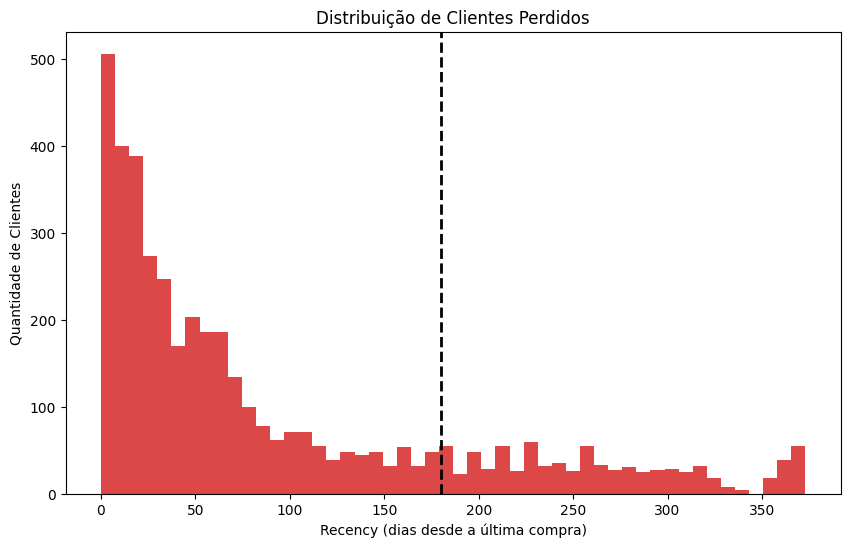

In [80]:
print("Quantidade de Clientes Perdidos:", len(churned_customers))
plt.figure(figsize=(10, 6))
plt.hist(df_full_clustering['Recency'], bins=50, color=PALETA[3], alpha=0.85)
plt.axvline(churn_threshold, color='black', linestyle='dashed', linewidth=2)
plt.title('Distribuição de Clientes Perdidos')
plt.xlabel('Recency (dias desde a última compra)')
plt.ylabel('Quantidade de Clientes')
plt.show()